# Bitcoin Time Series Forecasting  - Part 3: Neural Network Classification

# Introduction

In the third part of the project I formulate Bitcoin price forecasting as a binary classification problem. I do this by training a multilayer perceptron on a sequence of past data points to predict a price increase or decrease in the next time step. Once again I do this on both the raw time series and the time series of returns. 

Loading several needed packages:

In [537]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
#%matplotlib # to prevent duplicate plots by statsmodels 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

<Figure size 432x288 with 0 Axes>

Loading the Keras package for neural network training.

In [538]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras import regularizers

### Data Loading and Preparation

The data loading and following few steps are repeats of the previous part.

In [539]:
data = pd.read_csv('c:\\users\jamil\AnacondaProjects\Mariani_Prado\Kraken_BTCUSD_1h.csv', index_col= 0)
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01-AM,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 12-AM,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 11-PM,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 10-PM,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 09-PM,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51


In [540]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %I-%p')
data.head(10)

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01:00:00,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 00:00:00,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 23:00:00,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 22:00:00,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 21:00:00,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51
2019-06-27 20:00:00,BTCUSD,10830.9,10899.8,10300.0,10678.8,1489.22,15715577.13
2019-06-27 19:00:00,BTCUSD,10995.4,10995.4,10520.4,10830.9,1191.77,12846614.99
2019-06-27 18:00:00,BTCUSD,10805.5,11097.5,10638.6,10995.4,971.41,10603374.74
2019-06-27 17:00:00,BTCUSD,10887.6,10920.0,10355.2,10805.5,2331.37,24900968.86


In [541]:
data=data.reindex(index=data.index[::-1])
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2017-07-01 11:00:00,BTCUSD,2491.97,2494.93,2483.32,2494.87,163.92,407837.90
2017-07-01 12:00:00,BTCUSD,2494.87,2494.87,2470.86,2477.97,80.93,200771.78
2017-07-01 13:00:00,BTCUSD,2477.97,2478.96,2444.44,2444.44,168.69,415839.42
2017-07-01 14:00:00,BTCUSD,2444.44,2463.60,2437.26,2448.99,119.59,292801.90
2017-07-01 15:00:00,BTCUSD,2448.99,2465.95,2438.99,2457.84,109.53,268333.15


Extracting the time series closing Bitcoin prices.

In [542]:
rawdata = (data['Close'])

In [543]:
rawdata.head()

Date
2017-07-01 11:00:00    2494.87
2017-07-01 12:00:00    2477.97
2017-07-01 13:00:00    2444.44
2017-07-01 14:00:00    2448.99
2017-07-01 15:00:00    2457.84
Name: Close, dtype: float64

### Bitcoin Price Time Series

<AxesSubplot:xlabel='Date'>

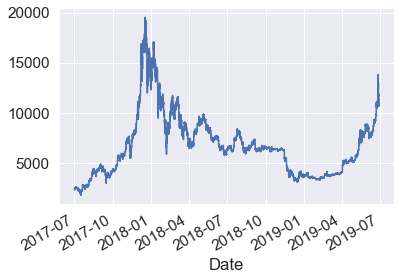

In [544]:
rawdata.plot()

<AxesSubplot:ylabel='Frequency'>

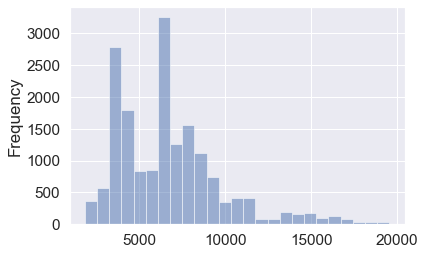

In [545]:
rawdata.plot.hist(bins=25, alpha=0.5)

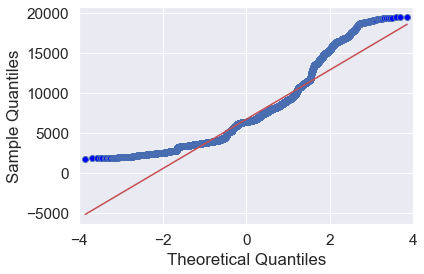

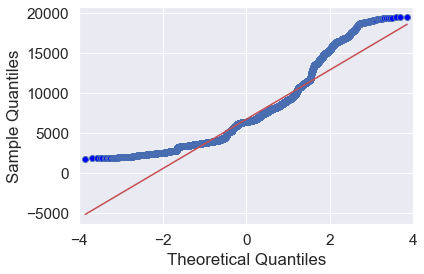

In [546]:
qqplot(rawdata, line='s')

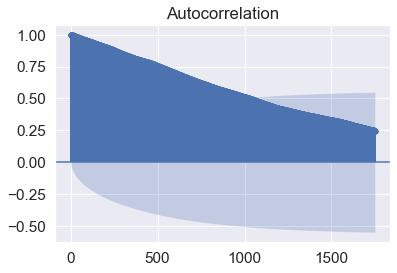

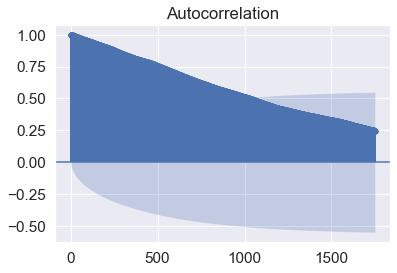

In [547]:
sm.graphics.tsa.plot_acf(rawdata, lags=1750)

### The Time Series of First Differences or Returns

<AxesSubplot:xlabel='Date'>

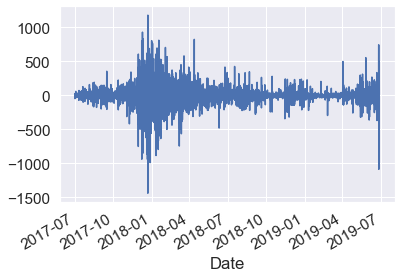

In [548]:
shiftdata = rawdata.shift(1)
diff = rawdata - shiftdata
diff.dropna()
diff.plot()

In [549]:
len(diff)

17439

In [550]:
diff.head()

Date
2017-07-01 11:00:00      NaN
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
Name: Close, dtype: float64

In [551]:
diff = diff.dropna()

In [552]:
diff.head()

Date
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
2017-07-01 16:00:00    -1.39
Name: Close, dtype: float64

<AxesSubplot:ylabel='Frequency'>

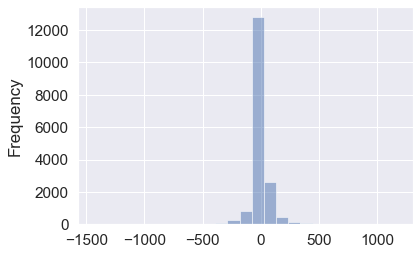

In [553]:
diff.plot.hist(bins=25, alpha=0.5)

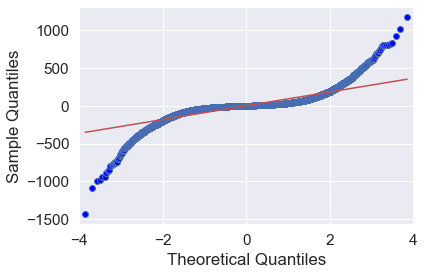

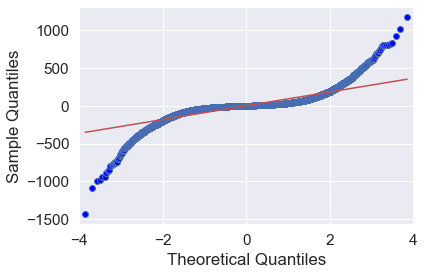

In [554]:
qqplot(diff, line='s')

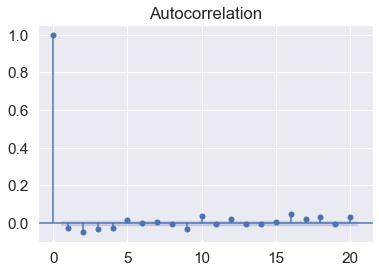

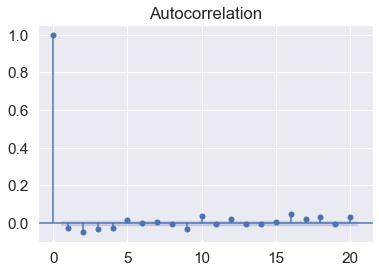

In [555]:
sm.graphics.tsa.plot_acf(diff, lags=20)

##  Neural Network Forecasting of the Raw Bitcoin Time Series

## Data Preparation for Binary Classification - Raw Time Series

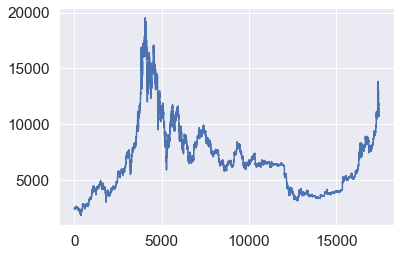

In [556]:
data = rawdata.values
plt.plot(data)

In [557]:
WINDOW = 30
STEP = 1
FORECAST = 1

In [558]:
# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1]
        else:
            y_i = [0] 

    except Exception as e:
        print ("e")
        break

    X.append(x_i)
    Y.append(y_i)

e


In [559]:
import numpy.ma as ma

In [560]:
X = np.where(np.isnan(X), ma.array(X, mask=np.isnan(X)).mean(axis=0), X)
print(X.shape)
X


(17408, 30)


array([[ 2494.87,  2477.97,  2444.44, ...,  2406.26,  2433.  ,  2448.  ],
       [ 2477.97,  2444.44,  2448.99, ...,  2433.  ,  2448.  ,  2470.01],
       [ 2444.44,  2448.99,  2457.84, ...,  2448.  ,  2470.01,  2475.  ],
       ...,
       [13580.  , 13456.4 , 13800.  , ..., 10830.9 , 10678.8 , 10729.  ],
       [13456.4 , 13800.  , 13839.  , ..., 10678.8 , 10729.  , 11089.4 ],
       [13800.  , 13839.  , 12751.3 , ..., 10729.  , 11089.4 , 11148.  ]])

In [561]:
Y = np.where(np.isnan(Y), ma.array(Y, mask=np.isnan(Y)).mean(axis=0), Y)
print(Y.shape)
Y

(17408, 1)


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [562]:
train_X = X[:int((len(X)+1)*.75)] 
test_X = X[int(len(X)*.75+1):] 

In [563]:
(train_X)

array([[2494.87, 2477.97, 2444.44, ..., 2406.26, 2433.  , 2448.  ],
       [2477.97, 2444.44, 2448.99, ..., 2433.  , 2448.  , 2470.01],
       [2444.44, 2448.99, 2457.84, ..., 2448.  , 2470.01, 2475.  ],
       ...,
       [3729.7 , 3744.8 , 3727.8 , ..., 3638.7 , 3617.9 , 3614.2 ],
       [3744.8 , 3727.8 , 3744.  , ..., 3617.9 , 3614.2 , 3615.4 ],
       [3727.8 , 3744.  , 3747.1 , ..., 3614.2 , 3615.4 , 3827.  ]])

In [564]:
len(test_X)

4351

In [565]:
train_Y = Y[:int((len(Y)+1)*.75)] 
test_Y = Y[int(len(Y)*.75+1):] 

In [566]:
len(test_Y)

4351

In [567]:
len(train_Y)

13056

In [568]:
# normalize data

# fit scaler on training data
#norm = MinMaxScaler().fit(train_X)
norm = StandardScaler().fit(train_X)

# transform training data
X_train = norm.transform(train_X)

# transform testing dataabs
X_test = norm.transform(test_X)

In [569]:
Y_train = train_Y
Y_test =  test_Y

In [570]:
X_train.shape, X_test.shape
X_train

array([[-1.46032392, -1.46567531, -1.47621108, ..., -1.49026539,
        -1.4820089 , -1.47742525],
       [-1.46559018, -1.47612408, -1.47479313, ..., -1.48192428,
        -1.47732971, -1.47055903],
       [-1.47603857, -1.47470619, -1.47203514, ..., -1.47724526,
        -1.47046378, -1.46900235],
       ...,
       [-1.07553481, -1.07089968, -1.07626893, ..., -1.1058253 ,
        -1.11238425, -1.11361867],
       [-1.07082946, -1.0761973 , -1.07122042, ..., -1.11231353,
        -1.11353845, -1.11324432],
       [-1.07612688, -1.07114898, -1.07025435, ..., -1.11346769,
        -1.11316412, -1.04723379]])

In [571]:
X_test

array([[-1.07011275, -1.06634996, -1.06953758, ..., -1.04708811,
        -1.0378292 , -1.03856133],
       [-1.06627991, -1.06946621, -1.07240464, ..., -1.03776128,
        -1.03848428, -1.03525457],
       [-1.06939604, -1.07233316, -1.07034784, ..., -1.03841634,
        -1.03517766, -1.02876582],
       ...,
       [ 1.99394695,  1.95547555,  2.06259876, ...,  1.13766729,
         1.09023422,  1.10590718],
       [ 1.95543158,  2.06254983,  2.07475259, ...,  1.09022211,
         1.10589391,  1.2183372 ],
       [ 2.06250181,  2.0747032 ,  1.7357853 , ...,  1.10588121,
         1.21831919,  1.236618  ]])

In [572]:
Y_train.shape, Y_test.shape

((13056, 1), (4351, 1))

In [573]:
Y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

An imbalanced dataset can affect classification performance so checking the total price increase and decrease labels in the training data:

In [574]:
totinc = (np.sum(Y_train))
print("The number of price INCREASE labels in the dataset are {}".format(totinc))

The number of price INCREASE labels in the dataset are 6613.0


In [575]:
print("The number of price DECREASE labels in the dataset are {}".format(int(len(Y_train) - totinc)))

The number of price DECREASE labels in the dataset are 6443


Therefore the two labels are well balanced in the dataset.

## Neural Network Model Specification

I now specify the neural network topology. Note the choice of activation function, loss function and metric reflect the fact that this is now a classification problem not a regression one. This neural network model will be used for both time series.

In [576]:
model = Sequential()
model.add(Dense(32, input_dim= WINDOW,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5)) # was originally 0.5 but caused test accuracy to be better than train accuracy
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('sigmoid'))

#opt = Nadam(lr=0.0001)
opt = Nadam()


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=25, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer= opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [577]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                992       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_15 (Batc (None, 16)                64        
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16)               

### Neural Network Model Fitting to the Raw Time Series

In [578]:
history = model.fit(X_train, Y_train, 
          epochs = 300, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          )

Epoch 1/300
102/102 [==============================] - 2s 6ms/step - loss: 1.0887 - accuracy: 0.5061 - val_loss: 0.7010 - val_accuracy: 0.5263

Epoch 00001: val_loss improved from inf to 0.70103, saving model to test.hdf5
Epoch 2/300
102/102 [==============================] - 0s 3ms/step - loss: 0.8224 - accuracy: 0.5011 - val_loss: 0.6988 - val_accuracy: 0.5240

Epoch 00002: val_loss improved from 0.70103 to 0.69877, saving model to test.hdf5
Epoch 3/300
102/102 [==============================] - 0s 2ms/step - loss: 0.7789 - accuracy: 0.5070 - val_loss: 0.6977 - val_accuracy: 0.5261

Epoch 00003: val_loss improved from 0.69877 to 0.69769, saving model to test.hdf5
Epoch 4/300
102/102 [==============================] - 0s 3ms/step - loss: 0.7606 - accuracy: 0.5073 - val_loss: 0.6989 - val_accuracy: 0.5282

Epoch 00004: val_loss did not improve from 0.69769
Epoch 5/300
102/102 [==============================] - 0s 3ms/step - loss: 0.7499 - accuracy: 0.5003 - val_loss: 0.6995 - val_accur

102/102 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5182 - val_loss: 0.6948 - val_accuracy: 0.5247

Epoch 00040: val_loss did not improve from 0.69340
Epoch 41/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6976 - accuracy: 0.5106 - val_loss: 0.6937 - val_accuracy: 0.5249

Epoch 00041: val_loss did not improve from 0.69340
Epoch 42/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5176 - val_loss: 0.6950 - val_accuracy: 0.4902

Epoch 00042: val_loss did not improve from 0.69340
Epoch 43/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5156 - val_loss: 0.6942 - val_accuracy: 0.5222

Epoch 00043: val_loss did not improve from 0.69340
Epoch 44/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.5240 - val_loss: 0.6939 - val_accuracy: 0.5236

Epoch 00044: val_loss did not improve from 0.69340
Epoch 45/300
102/102 [===========

102/102 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5173 - val_loss: 0.6929 - val_accuracy: 0.5369

Epoch 00081: val_loss did not improve from 0.69251
Epoch 82/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5269 - val_loss: 0.6928 - val_accuracy: 0.5286

Epoch 00082: val_loss did not improve from 0.69251
Epoch 83/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5269 - val_loss: 0.6924 - val_accuracy: 0.5242

Epoch 00083: val_loss improved from 0.69251 to 0.69243, saving model to test.hdf5
Epoch 84/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5377 - val_loss: 0.6922 - val_accuracy: 0.5245

Epoch 00084: val_loss improved from 0.69243 to 0.69218, saving model to test.hdf5
Epoch 85/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5213 - val_loss: 0.6926 - val_accuracy: 0.5300

Epoch 00085: val_loss 


Epoch 00121: val_loss did not improve from 0.69161
Epoch 122/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5300 - val_loss: 0.6927 - val_accuracy: 0.5440

Epoch 00122: val_loss did not improve from 0.69161
Epoch 123/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5265 - val_loss: 0.6924 - val_accuracy: 0.5325

Epoch 00123: val_loss did not improve from 0.69161
Epoch 124/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5284 - val_loss: 0.6924 - val_accuracy: 0.5337

Epoch 00124: val_loss did not improve from 0.69161
Epoch 125/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5387 - val_loss: 0.6960 - val_accuracy: 0.4889

Epoch 00125: val_loss did not improve from 0.69161
Epoch 126/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5233 - val_loss: 0.6937 - val_accuracy: 0.4960

Epoch 00126: v

102/102 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5308 - val_loss: 0.6913 - val_accuracy: 0.5307

Epoch 00163: val_loss did not improve from 0.69111
Epoch 164/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5305 - val_loss: 0.6916 - val_accuracy: 0.5247

Epoch 00164: val_loss did not improve from 0.69111
Epoch 165/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5301 - val_loss: 0.6921 - val_accuracy: 0.5242

Epoch 00165: val_loss did not improve from 0.69111
Epoch 166/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5279 - val_loss: 0.6923 - val_accuracy: 0.5348

Epoch 00166: val_loss did not improve from 0.69111
Epoch 167/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5433 - val_loss: 0.6920 - val_accuracy: 0.5247

Epoch 00167: val_loss did not improve from 0.69111
Epoch 168/300
102/102 [======

102/102 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5358 - val_loss: 0.6916 - val_accuracy: 0.5282

Epoch 00204: val_loss did not improve from 0.69062
Epoch 205/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5374 - val_loss: 0.6915 - val_accuracy: 0.5265

Epoch 00205: val_loss did not improve from 0.69062
Epoch 206/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5357 - val_loss: 0.6930 - val_accuracy: 0.5259

Epoch 00206: val_loss did not improve from 0.69062
Epoch 207/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5287 - val_loss: 0.6912 - val_accuracy: 0.5252

Epoch 00207: val_loss did not improve from 0.69062
Epoch 208/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5341 - val_loss: 0.6910 - val_accuracy: 0.5305

Epoch 00208: val_loss did not improve from 0.69062
Epoch 209/300
102/102 [======

102/102 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5355 - val_loss: 0.6911 - val_accuracy: 0.5233

Epoch 00245: val_loss did not improve from 0.69024
Epoch 246/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5370 - val_loss: 0.6909 - val_accuracy: 0.5272

Epoch 00246: val_loss did not improve from 0.69024
Epoch 247/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.5331 - val_loss: 0.6909 - val_accuracy: 0.5291

Epoch 00247: val_loss did not improve from 0.69024
Epoch 248/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5353 - val_loss: 0.6908 - val_accuracy: 0.5371

Epoch 00248: val_loss did not improve from 0.69024
Epoch 249/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5422 - val_loss: 0.6912 - val_accuracy: 0.5259

Epoch 00249: val_loss did not improve from 0.69024
Epoch 250/300
102/102 [======

102/102 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5416 - val_loss: 0.6923 - val_accuracy: 0.5079

Epoch 00286: val_loss did not improve from 0.69003
Epoch 287/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5439 - val_loss: 0.6922 - val_accuracy: 0.5095

Epoch 00287: val_loss did not improve from 0.69003
Epoch 288/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5459 - val_loss: 0.6925 - val_accuracy: 0.5040

Epoch 00288: val_loss did not improve from 0.69003
Epoch 289/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5374 - val_loss: 0.6913 - val_accuracy: 0.5238

Epoch 00289: val_loss did not improve from 0.69003
Epoch 290/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5411 - val_loss: 0.6920 - val_accuracy: 0.5272

Epoch 00290: val_loss did not improve from 0.69003
Epoch 291/300
102/102 [======

### Results

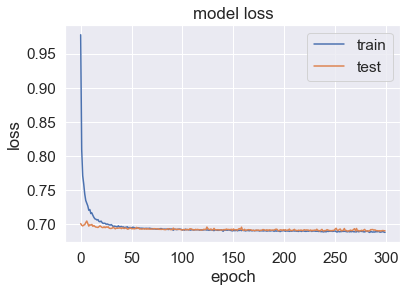

In [579]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

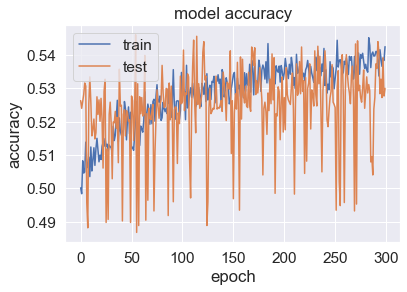

In [580]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [581]:
(Y_test).shape

(4351, 1)

In [582]:
prediction = model.predict(X_test)
(prediction).shape
y_pred = (prediction > 0.5)
y_test = (Y_test > 0.5)
print(y_test)

[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]


In [583]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[ 431 1619]
 [ 426 1875]]


<AxesSubplot:>

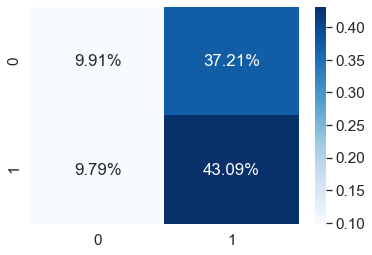

In [584]:
import seaborn as sn

sn.set(font_scale=1.4) # for label size
#sn.heatmap(confusion, annot=True, annot_kws={"size": 16}) # font size
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')

An example of another confusion matrix obtained by the algorithm while retaining the overall accuracy at the same rate.

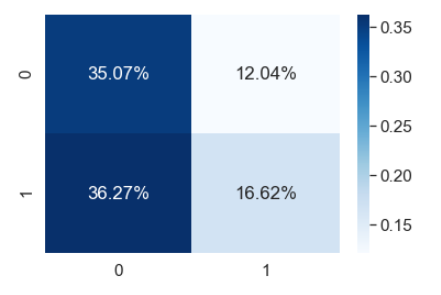

 The performance of the neural network is highly variable. Different runs give qualitatively three quite different results. The over all accuracy does not vary much at 53-54%. However, sometimes the true postive rate goes as high as 46% but this is always acompanied by a false negative rate also goes over 40%.  The neural network is correctly identifying price increases but at the same time misclassifing price decreases. Occaisionally, the the confusion matrix is much better behaved. The overall accuracy stays around the same at 54% but true postive and true negative rates of  around 27% are obtained. Other times the true negative rate is high but so is the false positive.

In [585]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

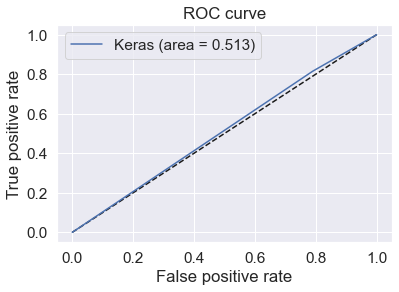

In [586]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

In [587]:
print(classification_report(y_test, y_pred,
target_names=[" price increase", "price decrease"]))

                 precision    recall  f1-score   support

 price increase       0.50      0.21      0.30      2050
 price decrease       0.54      0.81      0.65      2301

       accuracy                           0.53      4351
      macro avg       0.52      0.51      0.47      4351
   weighted avg       0.52      0.53      0.48      4351



### Discussion

The neural network accuracy rate of around 52-53% could be the basis of a trading algorithm if consistent but the false negative rate is too high i.e. this is reflected in a very poor recall.

## Forecasting of the First Differenced  Bitcoin Time Series

### Data Preparation for Binary Classification - Returns Time Series

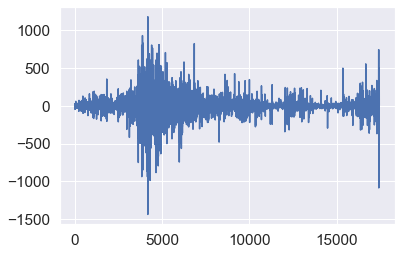

In [588]:
data =diff.values.tolist()
plt.plot(data)

In [589]:
# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if  next_close > 0:   # The condition corresponding to price increase in the next step for returns time series
            y_i = [1]
        else:
            y_i = [0] 

    except Exception as e:
        print ("e")
        break

    X.append(x_i)
    Y.append(y_i)

e


In [590]:
X = np.where(np.isnan(X), ma.array(X, mask=np.isnan(X)).mean(axis=0), X)
print(X.shape)
X

(17407, 30)


array([[  -16.9 ,   -33.53,     4.55, ...,    26.74,    15.  ,    22.01],
       [  -33.53,     4.55,     8.85, ...,    15.  ,    22.01,     4.99],
       [    4.55,     8.85,    -1.39, ...,    22.01,     4.99,     7.94],
       ...,
       [  743.8 ,  -123.6 ,   343.6 , ...,  -164.5 ,  -152.1 ,    50.2 ],
       [ -123.6 ,   343.6 ,    39.  , ...,  -152.1 ,    50.2 ,   360.4 ],
       [  343.6 ,    39.  , -1087.7 , ...,    50.2 ,   360.4 ,    58.6 ]])

In [591]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

C:\Users\jamil\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [592]:
Y = np.where(np.isnan(Y), ma.array(Y, mask=np.isnan(Y)).mean(axis=0), Y)
print(Y.shape)
Y

(17407,)


array([1., 1., 1., ..., 1., 1., 1.])

In [593]:
train_X = X[:int((len(X)+1)*.75)] 
test_X = X[int(len(X)*.75+1):] 

In [594]:
train_Y = Y[:int((len(Y)+1)*.75)] 
test_Y = Y[int(len(Y)*.75+1):]

In [595]:
# normalize data

# fit scaler on training data
#norm = MinMaxScaler().fit(train_X)
norm = StandardScaler().fit(train_X)

# transform training data
X_train = norm.transform(train_X)

# transform testing dataabs
X_test = norm.transform(test_X)

In [596]:
Y_train = train_Y
Y_test =  test_Y

In [597]:
Y_test

array([1., 1., 0., ..., 1., 1., 1.])

In [598]:
X_train.shape, X_test.shape
X_train

array([[-0.16860434, -0.33359658,  0.044139  , ...,  0.26434274,
         0.14771669,  0.21723267],
       [-0.33358104,  0.04417366,  0.08679703, ...,  0.14788166,
         0.21724453,  0.04842228],
       [ 0.04418881,  0.08683153, -0.01478862, ...,  0.21742103,
         0.04843372,  0.07768142],
       ...,
       [ 0.14884931, -0.16961176,  0.15971251, ..., -0.20725522,
        -0.037757  ,  0.01083171],
       [-0.16959639,  0.15974675,  0.02975431, ..., -0.0376228 ,
         0.01084306,  2.09765345],
       [ 0.15976177,  0.02978902,  0.12102267, ...,  0.01098532,
         2.09767004,  0.29548848]])

In [599]:
X_test

array([[  0.02980419,   0.12105704,  -0.1002039 , ...,   2.09815848,
          0.29550054,  -0.02189885],
       [  0.12107211,  -0.1001687 ,  -0.09226752, ...,   0.29569002,
         -0.02188759,   0.10406425],
       [ -0.1001534 ,  -0.09223235,   0.06447597, ...,  -0.02175076,
          0.10407583,   0.20523146],
       ...,
       [  7.3778641 ,  -1.22713034,   3.4076756 , ...,  -1.63276275,
         -1.50964446,   0.49683107],
       [ -1.22711385,   3.40769781,   0.38589931, ...,  -1.50975444,
          0.49684364,   3.57350457],
       [  3.40770941,   0.38593271, -10.79149839, ...,   0.49706652,
          3.57352485,   0.58014525]])

### Neural Network Model Fitting

In [609]:
history = model.fit(X_train, Y_train, 
          epochs = 300, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          )

Epoch 1/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5499 - val_loss: 0.6932 - val_accuracy: 0.5215

Epoch 00001: val_loss did not improve from 0.69003
Epoch 2/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5492 - val_loss: 0.6937 - val_accuracy: 0.5231

Epoch 00002: val_loss did not improve from 0.69003
Epoch 3/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5502 - val_loss: 0.6934 - val_accuracy: 0.5222

Epoch 00003: val_loss did not improve from 0.69003
Epoch 4/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5470 - val_loss: 0.6934 - val_accuracy: 0.5192

Epoch 00004: val_loss did not improve from 0.69003
Epoch 5/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5502 - val_loss: 0.6934 - val_accuracy: 0.5215

Epoch 00005: val_loss did not improve from 0.69003
Epoch 6/300
102/102 [====

102/102 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5452 - val_loss: 0.6938 - val_accuracy: 0.5185

Epoch 00043: val_loss did not improve from 0.69003
Epoch 44/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5439 - val_loss: 0.6936 - val_accuracy: 0.5180

Epoch 00044: val_loss did not improve from 0.69003
Epoch 45/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5460 - val_loss: 0.6934 - val_accuracy: 0.5213

Epoch 00045: val_loss did not improve from 0.69003
Epoch 46/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5471 - val_loss: 0.6933 - val_accuracy: 0.5155

Epoch 00046: val_loss did not improve from 0.69003
Epoch 47/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.5538 - val_loss: 0.6938 - val_accuracy: 0.5208

Epoch 00047: val_loss did not improve from 0.69003
Epoch 48/300
102/102 [===========

102/102 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.5525 - val_loss: 0.6936 - val_accuracy: 0.5153

Epoch 00085: val_loss did not improve from 0.69003
Epoch 86/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5484 - val_loss: 0.6932 - val_accuracy: 0.5155

Epoch 00086: val_loss did not improve from 0.69003
Epoch 87/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.5488 - val_loss: 0.6931 - val_accuracy: 0.5178

Epoch 00087: val_loss did not improve from 0.69003
Epoch 88/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5531 - val_loss: 0.6930 - val_accuracy: 0.5187

Epoch 00088: val_loss did not improve from 0.69003
Epoch 89/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5485 - val_loss: 0.6929 - val_accuracy: 0.5190

Epoch 00089: val_loss did not improve from 0.69003
Epoch 90/300
102/102 [===========


Epoch 00126: val_loss did not improve from 0.69003
Epoch 127/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5494 - val_loss: 0.6932 - val_accuracy: 0.5162

Epoch 00127: val_loss did not improve from 0.69003
Epoch 128/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.5555 - val_loss: 0.6931 - val_accuracy: 0.5222

Epoch 00128: val_loss did not improve from 0.69003
Epoch 129/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.5523 - val_loss: 0.6931 - val_accuracy: 0.5215

Epoch 00129: val_loss did not improve from 0.69003
Epoch 130/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5402 - val_loss: 0.6932 - val_accuracy: 0.5231

Epoch 00130: val_loss did not improve from 0.69003
Epoch 131/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.5483 - val_loss: 0.6934 - val_accuracy: 0.5219

Epoch 00131: v

102/102 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.5483 - val_loss: 0.6932 - val_accuracy: 0.5144

Epoch 00168: val_loss did not improve from 0.69003
Epoch 169/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.5532 - val_loss: 0.6931 - val_accuracy: 0.5174

Epoch 00169: val_loss did not improve from 0.69003
Epoch 170/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5476 - val_loss: 0.6932 - val_accuracy: 0.5160

Epoch 00170: val_loss did not improve from 0.69003
Epoch 171/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.5542 - val_loss: 0.6932 - val_accuracy: 0.5167

Epoch 00171: val_loss did not improve from 0.69003
Epoch 172/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.5503 - val_loss: 0.6931 - val_accuracy: 0.5238

Epoch 00172: val_loss did not improve from 0.69003
Epoch 173/300
102/102 [======


Epoch 00209: val_loss did not improve from 0.69003
Epoch 210/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5462 - val_loss: 0.6936 - val_accuracy: 0.5141

Epoch 00210: val_loss did not improve from 0.69003
Epoch 211/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.5523 - val_loss: 0.6935 - val_accuracy: 0.5137

Epoch 00211: val_loss did not improve from 0.69003
Epoch 212/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.5512 - val_loss: 0.6934 - val_accuracy: 0.5109

Epoch 00212: val_loss did not improve from 0.69003
Epoch 213/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.5512 - val_loss: 0.6937 - val_accuracy: 0.5111

Epoch 00213: val_loss did not improve from 0.69003
Epoch 214/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5518 - val_loss: 0.6937 - val_accuracy: 0.5139

Epoch 00214: v

102/102 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.5534 - val_loss: 0.6933 - val_accuracy: 0.5116

Epoch 00251: val_loss did not improve from 0.69003
Epoch 252/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.5514 - val_loss: 0.6931 - val_accuracy: 0.5162

Epoch 00252: val_loss did not improve from 0.69003
Epoch 253/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.5445 - val_loss: 0.6932 - val_accuracy: 0.5169

Epoch 00253: val_loss did not improve from 0.69003
Epoch 254/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5495 - val_loss: 0.6933 - val_accuracy: 0.5151

Epoch 00254: val_loss did not improve from 0.69003
Epoch 255/300
102/102 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.5604 - val_loss: 0.6936 - val_accuracy: 0.5167

Epoch 00255: val_loss did not improve from 0.69003
Epoch 256/300
102/102 [======


Epoch 00292: val_loss did not improve from 0.69003
Epoch 293/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5524 - val_loss: 0.6932 - val_accuracy: 0.5180

Epoch 00293: val_loss did not improve from 0.69003
Epoch 294/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5534 - val_loss: 0.6931 - val_accuracy: 0.5178

Epoch 00294: val_loss did not improve from 0.69003
Epoch 295/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5522 - val_loss: 0.6931 - val_accuracy: 0.5164

Epoch 00295: val_loss did not improve from 0.69003
Epoch 296/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5552 - val_loss: 0.6932 - val_accuracy: 0.5174

Epoch 00296: val_loss did not improve from 0.69003
Epoch 297/300
102/102 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5541 - val_loss: 0.6932 - val_accuracy: 0.5146

Epoch 00297: v

### Results

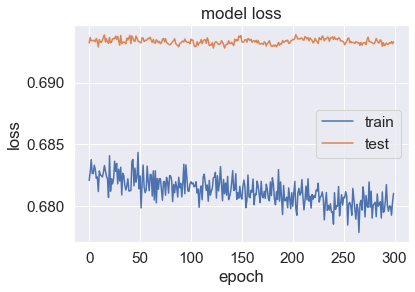

In [610]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

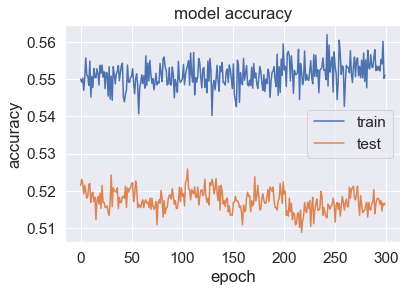

In [611]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [612]:
prediction = model.predict(X_test)
(prediction).shape
y_pred = (prediction > 0.5)
y_test = (Y_test > 0.5)
print(y_test)

[ True  True False ...  True  True  True]


In [613]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[1143  912]
 [1191 1105]]


<AxesSubplot:>

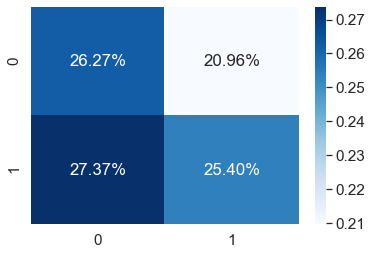

In [614]:

sn.set(font_scale=1.4) # for label size
#sn.heatmap(confusion, annot=True, annot_kws={"size": 16}) # font size
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')

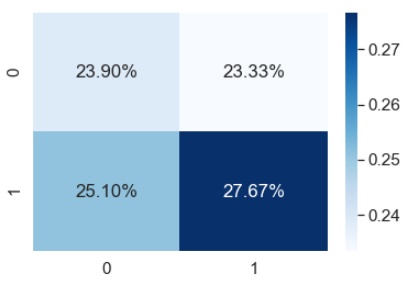

The confusion matrices for the return time series exhibit three different kinds of behaviour similar to the case of the raw time series except that percentages are not as large and small and close to the mid 20%s.

In [615]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

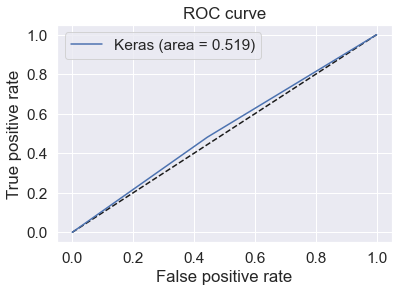

In [616]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

In [617]:
print(classification_report(y_test, y_pred,
target_names=[" price increase", "price decrease"]))

                 precision    recall  f1-score   support

 price increase       0.49      0.56      0.52      2055
 price decrease       0.55      0.48      0.51      2296

       accuracy                           0.52      4351
      macro avg       0.52      0.52      0.52      4351
   weighted avg       0.52      0.52      0.52      4351



### Discussion

The true negative rate with the time series of returns is quite good but the false negative rate is too high. Moreover, the accuracy is hardly better than chance. Therefore this framework cannot be the basis of a trading system. The use of fractionl differencing is one potential way of improving classification performance.

# Conclusion

The neyral network classifier with either the raw Bitcoin time series of the time series of returns does not give a satisfactory performance. It could not, for instance, be the basis of an automated trading system.